In [1]:
!nvidia-smi

Sat Jan  9 08:28:29 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
##library import
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
import re
from PIL import Image
import shutil
import random
import matplotlib.pyplot as plt

In [3]:
print(tf.__version__)
print(keras.__version__)

2.4.0
2.4.0


## Data 준비

In [4]:
## google drive에서 압축된 dataset download
import gdown
url = 'https://drive.google.com/uc?id=1dIR9ANjUsV9dWa0pS9J0c2KUGMfpIRG0'
fname = 'oxford_pet.zip'
gdown.download(url, fname, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1dIR9ANjUsV9dWa0pS9J0c2KUGMfpIRG0
To: /content/oxford_pet.zip
811MB [00:13, 59.0MB/s]


'oxford_pet.zip'

In [5]:
!ls -l

total 791576
-rw-r--r-- 1 root root 810565619 Jan  9 08:28 oxford_pet.zip
drwxr-xr-x 1 root root      4096 Jan  6 18:10 sample_data


In [6]:
# 압출풀기
!unzip -q oxford_pet.zip -d oxford_pet

In [7]:
## 압축이 풀린 directtory 확인
!ls oxford_pet

annotations  images


In [8]:
## diretory 설정
cur_dir = os.getcwd()
data_dir = os.path.join(cur_dir, 'oxford_pet')
image_dir = os.path.join(data_dir, 'images')

In [9]:
## imgae file
image_files = [fname for fname in os.listdir(image_dir) if os.path.splitext(fname)[-1] == '.jpg']
print(len(image_files))

7390


In [10]:
## image file들을 읽어서 channel이 3이 아닌 image는 삭제
for image_file in image_files:
  image_path = os.path.join(image_dir, image_file)
  image = Image.open(image_path)
  image_mode = image.mode
  if image_mode != 'RGB':
    print(image_file, image_mode)
    image = np.asarray(image)
    print(image.shape)
    os.remove(image_path)

Egyptian_Mau_191.jpg P
(214, 300)
Egyptian_Mau_145.jpg P
(188, 216)
staffordshire_bull_terrier_2.jpg L
(282, 500)
Abyssinian_34.jpg P
(202, 250)
staffordshire_bull_terrier_22.jpg L
(500, 364)
Egyptian_Mau_139.jpg P
(250, 350)
Egyptian_Mau_177.jpg P
(175, 246)
Egyptian_Mau_167.jpg P
(275, 183)
Abyssinian_5.jpg RGBA
(150, 200, 4)
Egyptian_Mau_129.jpg L
(325, 299)
Egyptian_Mau_186.jpg RGBA
(275, 183, 4)
Egyptian_Mau_14.jpg RGBA
(800, 582, 4)


In [11]:
## image file 수 확인
image_files = [fname for fname in os.listdir(image_dir) if os.path.splitext(fname)[-1] == '.jpg']
print(len(image_files))

7378


In [12]:
class_list = set()
for image_file in image_files:
  file_name = os.path.splitext(image_file)[0]
  class_name = re.sub('_\d+', '', file_name)
  class_list.add(class_name)
class_list = list(class_list)
print(len(class_list))

37


In [13]:
class_list.sort()
class_list

['Abyssinian',
 'Bengal',
 'Birman',
 'Bombay',
 'British_Shorthair',
 'Egyptian_Mau',
 'Maine_Coon',
 'Persian',
 'Ragdoll',
 'Russian_Blue',
 'Siamese',
 'Sphynx',
 'american_bulldog',
 'american_pit_bull_terrier',
 'basset_hound',
 'beagle',
 'boxer',
 'chihuahua',
 'english_cocker_spaniel',
 'english_setter',
 'german_shorthaired',
 'great_pyrenees',
 'havanese',
 'japanese_chin',
 'keeshond',
 'leonberger',
 'miniature_pinscher',
 'newfoundland',
 'pomeranian',
 'pug',
 'saint_bernard',
 'samoyed',
 'scottish_terrier',
 'shiba_inu',
 'staffordshire_bull_terrier',
 'wheaten_terrier',
 'yorkshire_terrier']

In [14]:
class_list[1]

'Bengal'

In [15]:
class2idx = {cls:idx for idx, cls in enumerate(class_list)}
class2idx

{'Abyssinian': 0,
 'Bengal': 1,
 'Birman': 2,
 'Bombay': 3,
 'British_Shorthair': 4,
 'Egyptian_Mau': 5,
 'Maine_Coon': 6,
 'Persian': 7,
 'Ragdoll': 8,
 'Russian_Blue': 9,
 'Siamese': 10,
 'Sphynx': 11,
 'american_bulldog': 12,
 'american_pit_bull_terrier': 13,
 'basset_hound': 14,
 'beagle': 15,
 'boxer': 16,
 'chihuahua': 17,
 'english_cocker_spaniel': 18,
 'english_setter': 19,
 'german_shorthaired': 20,
 'great_pyrenees': 21,
 'havanese': 22,
 'japanese_chin': 23,
 'keeshond': 24,
 'leonberger': 25,
 'miniature_pinscher': 26,
 'newfoundland': 27,
 'pomeranian': 28,
 'pug': 29,
 'saint_bernard': 30,
 'samoyed': 31,
 'scottish_terrier': 32,
 'shiba_inu': 33,
 'staffordshire_bull_terrier': 34,
 'wheaten_terrier': 35,
 'yorkshire_terrier': 36}

In [16]:
class2idx['Bengal']

1

In [17]:
## train, validation directory  생성
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'validation')
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

In [18]:
image_files.sort()

In [19]:
cnt = 0
previous_class = ""
for image_file in image_files:
  file_name = os.path.splitext(image_file)[0]
  class_name = re.sub('_\d+','',file_name)
  if class_name == previous_class:
    cnt += 1
  else:
    cnt = 1
  if cnt <= 160:
    cpath = train_dir
  else:
    cpath = val_dir
  image_path = os.path.join(image_dir, image_file)
  shutil.copy(image_path, cpath)
  previous_class = class_name

In [20]:
train_images = os.listdir(train_dir)
val_images = os.listdir(val_dir)

In [21]:
print(len(train_images), len(val_images))

5920 1458


In [22]:
train_images[:10]

['scottish_terrier_38.jpg',
 'British_Shorthair_165.jpg',
 'american_pit_bull_terrier_200.jpg',
 'chihuahua_21.jpg',
 'beagle_13.jpg',
 'english_cocker_spaniel_151.jpg',
 'samoyed_162.jpg',
 'Birman_142.jpg',
 'wheaten_terrier_164.jpg',
 'german_shorthaired_199.jpg']

In [23]:
val_images[:10]

['Maine_Coon_56.jpg',
 'newfoundland_81.jpg',
 'Sphynx_55.jpg',
 'Bombay_68.jpg',
 'Ragdoll_64.jpg',
 'american_bulldog_85.jpg',
 'scottish_terrier_77.jpg',
 'yorkshire_terrier_65.jpg',
 'yorkshire_terrier_86.jpg',
 'miniature_pinscher_85.jpg']

## TFRecord File 만들기

In [24]:
IMG_SIZE = 224

In [25]:
## TFRecord 저장할 directory와 file 경로 설정
tfr_dir = os.path.join(data_dir, 'tfrecord')
os.makedirs(tfr_dir, exist_ok=True)

tfr_train_dir = os.path.join(tfr_dir, 'cls_train.tfr')
tfr_val_dir = os.path.join(tfr_dir, 'cls_val.tfr')

In [26]:
## TFRecord writer 생성
writer_train = tf.io.TFRecordWriter(tfr_train_dir)
writer_val = tf.io.TFRecordWriter(tfr_val_dir)

In [27]:
# The following functions can be used to convert a value to a type compatible
# with tf.train.Example.

def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
  """Returns a float_list from a float / double."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [28]:
## Training data로 tfrecord 만들기
n_train = 0

train_files = os.listdir(train_dir)
for train_file in train_files:
  train_path = os.path.join(train_dir, train_file)
  image = Image.open(train_path)
  image = image.resize((IMG_SIZE, IMG_SIZE))
  bimage = image.tobytes()

  file_name = os.path.splitext(train_file)[0] #Bangal_101
  class_name = re.sub('_\d+', '', file_name)
  class_num = class2idx[class_name]

  example = tf.train.Example(features=tf.train.Features(feature={
      'image': _bytes_feature(bimage),
      'cls_num': _int64_feature(class_num)
  }))
  writer_train.write(example.SerializeToString())
  n_train += 1

writer_train.close()
print(n_train)

5920


In [29]:
## Validation data로 tfrecord 만들기
n_val = 0

val_files = os.listdir(val_dir)
for val_file in val_files:
  val_path = os.path.join(val_dir, val_file)
  image = Image.open(val_path)
  image = image.resize((IMG_SIZE, IMG_SIZE))
  bimage = image.tobytes()

  file_name = os.path.splitext(val_file)[0]
  class_name = re.sub('_\d+', '', file_name)
  class_num = class2idx[class_name]

  example = tf.train.Example(features=tf.train.Features(feature={
      'image': _bytes_feature(bimage),
      'cls_num': _int64_feature(class_num)
  }))
  writer_val.write(example.SerializeToString())
  n_val += 1
  
writer_val.close()
print(n_val)

1458


In [30]:
!ls -l $tfr_dir

total 1085016
-rw-r--r-- 1 root root 891486880 Jan  9 08:29 cls_train.tfr
-rw-r--r-- 1 root root 219558762 Jan  9 08:30 cls_val.tfr


## Classification

In [53]:
## Hyper Parameters
N_CLASS = len(class_list)
N_EPOCHS = 20
N_BATCH = 40
N_TRAIN = n_train
N_VAL = n_val
IMG_SIZE = 224
learning_rate = 0.0001
steps_per_epoch = N_TRAIN / N_BATCH
validation_steps = int(np.ceil(N_VAL / N_BATCH))

In [32]:
## tfrecord file을 data로 parsing해주는 function
def _parse_function(tfrecord_serialized):
  features = {'image': tf.io.FixedLenFeature([], tf.string),
              'cls_num': tf.io.FixedLenFeature([], tf.int64)
              }
  parsed_features = tf.io.parse_single_example(tfrecord_serialized, features)

  image = tf.io.decode_raw(parsed_features['image'], tf.uint8)
  image = tf.reshape(image, [IMG_SIZE, IMG_SIZE, 3])
  image = tf.cast(image, tf.float32)/255.

  label = tf.cast(parsed_features['cls_num'], tf.int64)

  return image, label

In [43]:
## train dataset 만들기
train_dataset = tf.data.TFRecordDataset(tfr_train_dir)
train_dataset = train_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(N_TRAIN).prefetch(
    tf.data.experimental.AUTOTUNE).batch(N_BATCH).repeat()

In [34]:
## valudation dataset 만들기
val_dataset = tf.data.TFRecordDataset(tfr_val_dir)
val_dataset = val_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.batch(N_BATCH).repeat()

<RepeatDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>


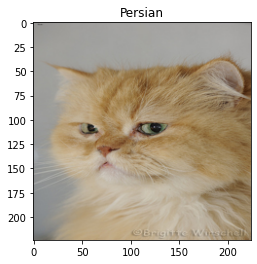

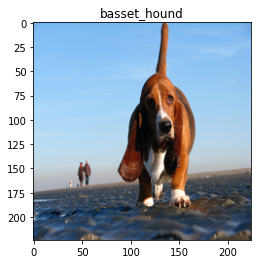

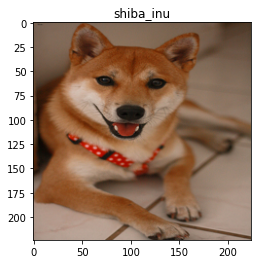

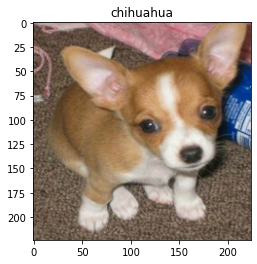

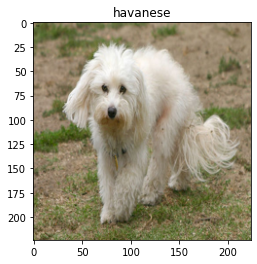

In [56]:
print(train_dataset)
for image, label in train_dataset.take(5):
  plt.imshow(image[0])
  title = class_list[label[0].numpy()]
  plt.title(title)
  plt.show()

In [49]:
# Sequential API를 사용하여 model 구성
def create_model():
  model = keras.Sequential()
  model.add(keras.layers.Conv2D(32, 3, activation='relu', padding='SAME',
                                input_shape=(IMG_SIZE,IMG_SIZE,3)))
  model.add(keras.layers.MaxPool2D(padding='SAME'))
  model.add(keras.layers.Conv2D(64, 3, activation='relu', padding='SAME',
                                input_shape=(IMG_SIZE,IMG_SIZE,3)))
  model.add(keras.layers.MaxPool2D(padding='SAME'))
  model.add(keras.layers.Conv2D(128, 3, activation='relu', padding='SAME',
                                input_shape=(IMG_SIZE,IMG_SIZE,3)))
  model.add(keras.layers.MaxPool2D(padding='SAME'))
  model.add(keras.layers.Conv2D(256, 3, activation='relu', padding='SAME',
                                input_shape=(IMG_SIZE,IMG_SIZE,3)))
  model.add(keras.layers.MaxPool2D(padding='SAME'))
  model.add(keras.layers.Conv2D(256, 3, activation='relu', padding='SAME',
                                input_shape=(IMG_SIZE,IMG_SIZE,3)))
  model.add(keras.layers.MaxPool2D(padding='SAME'))
  model.add(keras.layers.Flatten())
  model.add(keras.layers.Dense(1024, activation='relu'))
  model.add(keras.layers.Dropout(0.4))
  model.add(keras.layers.Dense(N_CLASS, activation='softmax'))
  return model

In [50]:
## Create model, compile & summary
model = create_model()

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 256)       2

In [58]:
history = model.fit(
    train_dataset,
    epochs = N_EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_dataset,
    validation_steps=validation_steps
)

Epoch 1/20
148/148 [==============================] - 13s 53ms/step - loss: 3.6087 - accuracy: 0.0311 - val_loss: 3.4398 - val_accuracy: 0.0823
Epoch 2/20
148/148 [==============================] - 9s 51ms/step - loss: 3.3548 - accuracy: 0.0838 - val_loss: 3.1492 - val_accuracy: 0.1317
Epoch 3/20
148/148 [==============================] - 9s 51ms/step - loss: 3.0784 - accuracy: 0.1575 - val_loss: 2.9997 - val_accuracy: 0.1701
Epoch 4/20
148/148 [==============================] - 9s 51ms/step - loss: 2.8425 - accuracy: 0.2038 - val_loss: 2.8809 - val_accuracy: 0.1914
Epoch 5/20
148/148 [==============================] - 9s 52ms/step - loss: 2.5766 - accuracy: 0.2903 - val_loss: 2.8076 - val_accuracy: 0.2222
Epoch 6/20
148/148 [==============================] - 9s 51ms/step - loss: 2.3278 - accuracy: 0.3358 - val_loss: 2.7467 - val_accuracy: 0.2407
Epoch 7/20
148/148 [==============================] - 9s 51ms/step - loss: 1.9911 - accuracy: 0.4379 - val_loss: 2.7882 - val_accuracy: 0.246

In [61]:
# Sequential API를 사용하여 model 구성
def create_bn_model():
  model = keras.Sequential()
  model.add(keras.layers.Conv2D(32, 3, padding='SAME',
                                input_shape=(IMG_SIZE,IMG_SIZE,3)))
  model.add(keras.layers.BatchNormalization())
  model.add(keras.layers.ReLU())
  model.add(keras.layers.MaxPool2D(padding='SAME'))
  model.add(keras.layers.Conv2D(64, 3, padding='SAME',
                                input_shape=(IMG_SIZE,IMG_SIZE,3)))
  model.add(keras.layers.BatchNormalization())
  model.add(keras.layers.ReLU())
  model.add(keras.layers.MaxPool2D(padding='SAME'))
  model.add(keras.layers.Conv2D(128, 3, padding='SAME',
                                input_shape=(IMG_SIZE,IMG_SIZE,3)))
  model.add(keras.layers.BatchNormalization())
  model.add(keras.layers.ReLU())
  model.add(keras.layers.MaxPool2D(padding='SAME'))
  model.add(keras.layers.Conv2D(256, 3, padding='SAME',
                                input_shape=(IMG_SIZE,IMG_SIZE,3)))
  model.add(keras.layers.BatchNormalization())
  model.add(keras.layers.ReLU())
  model.add(keras.layers.MaxPool2D(padding='SAME'))
  model.add(keras.layers.Conv2D(256, 3, padding='SAME',
                                input_shape=(IMG_SIZE,IMG_SIZE,3)))
  model.add(keras.layers.BatchNormalization())
  model.add(keras.layers.ReLU())
  model.add(keras.layers.MaxPool2D(padding='SAME'))
  model.add(keras.layers.Flatten())
  model.add(keras.layers.Dense(1024, activation='relu'))
  model.add(keras.layers.BatchNormalization())
  model.add(keras.layers.ReLU())
  model.add(keras.layers.Dense(N_CLASS, activation='softmax'))
  return model

In [63]:
## Create model, compile & summaryy
model = create_bn_model()

## learning rate scheduing
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=learning_rate,
                                                         decay_steps=steps_per_epoch*5,
                                                         decay_rate=0.5,
                                                         staircase=True)
model.compile(optimizer=tf.keras.optimizers.Adam(lr_schedule),
              loss ='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 224, 224, 32)      896       
_________________________________________________________________
batch_normalization_6 (Batch (None, 224, 224, 32)      128       
_________________________________________________________________
re_lu_6 (ReLU)               (None, 224, 224, 32)      0         
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 112, 112, 64)      18496     
_________________________________________________________________
batch_normalization_7 (Batch (None, 112, 112, 64)      256       
_________________________________________________________________
re_lu_7 (ReLU)               (None, 112, 112, 64)     

In [64]:
history =model.fit(
    train_dataset,
    epochs=N_EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_dataset,
    validation_steps=validation_steps
)

Epoch 1/20
148/148 [==============================] - 13s 71ms/step - loss: 3.5354 - accuracy: 0.1016 - val_loss: 4.4070 - val_accuracy: 0.0357
Epoch 2/20
148/148 [==============================] - 12s 69ms/step - loss: 1.9832 - accuracy: 0.4921 - val_loss: 4.6113 - val_accuracy: 0.0473
Epoch 3/20
148/148 [==============================] - 12s 69ms/step - loss: 1.2372 - accuracy: 0.7755 - val_loss: 3.4928 - val_accuracy: 0.0981
Epoch 4/20
148/148 [==============================] - 12s 69ms/step - loss: 0.8242 - accuracy: 0.9289 - val_loss: 3.2055 - val_accuracy: 0.1591
Epoch 5/20
148/148 [==============================] - 12s 69ms/step - loss: 0.5564 - accuracy: 0.9818 - val_loss: 3.2050 - val_accuracy: 0.1461
Epoch 6/20
148/148 [==============================] - 12s 69ms/step - loss: 0.2814 - accuracy: 0.9986 - val_loss: 2.7307 - val_accuracy: 0.2620
Epoch 7/20
148/148 [==============================] - 12s 69ms/step - loss: 0.1487 - accuracy: 1.0000 - val_loss: 2.7080 - val_accuracy:

## Pretrained MobileNetV2 사용하여 학습하기

In [70]:
from tensorflow.keras import models
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.layers import Conv2D, ReLU, MaxPooling2D, Dense, BatchNormalization, GlobalAveragePooling2D

In [73]:
mobilenetv2 = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

In [74]:
mobilenetv2.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [75]:
def create_mv_model():
  model = models.Sequential()
  model.add(mobilenetv2)
  model.add(GlobalAveragePooling2D())
  model.add(Dense(N_CLASS, activation='softmax'))
  return model

In [77]:
## Create model, compile & summary
model = create_mv_model()

## learning rate scheduing
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=learning_rate,
                                                          decay_steps=steps_per_epoch*5,
                                                          decay_rate=0.5,
                                                          staircase=True)
model.compile(optimizer=tf.keras.optimizers.Adam(lr_schedule),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 37)                47397     
Total params: 2,305,381
Trainable params: 2,271,269
Non-trainable params: 34,112
_________________________________________________________________


In [78]:
histroy = model.fit(
    train_dataset,
    epochs=N_EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_dataset,
    validation_steps=validation_steps
)

Epoch 1/20
148/148 [==============================] - 38s 213ms/step - loss: 2.0361 - accuracy: 0.5001 - val_loss: 0.5838 - val_accuracy: 0.8162
Epoch 2/20
148/148 [==============================] - 32s 206ms/step - loss: 0.2483 - accuracy: 0.9363 - val_loss: 0.4628 - val_accuracy: 0.8422
Epoch 3/20
148/148 [==============================] - 32s 208ms/step - loss: 0.1112 - accuracy: 0.9787 - val_loss: 0.3899 - val_accuracy: 0.8745
Epoch 4/20
148/148 [==============================] - 32s 208ms/step - loss: 0.0547 - accuracy: 0.9940 - val_loss: 0.3715 - val_accuracy: 0.8820
Epoch 5/20
148/148 [==============================] - 32s 206ms/step - loss: 0.0324 - accuracy: 0.9971 - val_loss: 0.4018 - val_accuracy: 0.8697
Epoch 6/20
148/148 [==============================] - 32s 208ms/step - loss: 0.0211 - accuracy: 0.9980 - val_loss: 0.3124 - val_accuracy: 0.9033
Epoch 7/20
148/148 [==============================] - 32s 205ms/step - loss: 0.0143 - accuracy: 0.9993 - val_loss: 0.2780 - val_ac